In [1]:
import cv2, imghdr, matplotlib as mpl, matplotlib.image as mpimg, \
       matplotlib.pyplot as plt, numpy as np, os, pandas as pd, \
       PIL, random, shutil, seaborn as sns, sklearn, sys, \
       tensorflow as tf, tensorflow_addons as tfa, time, yaml

from functools  import partial
from PIL        import Image
from tensorflow import keras
from keras      import layers
from tqdm       import tqdm

print(tf.__version__)
print(tf.config.list_physical_devices())

## change settings with yaml config
with open('6050_modeling.yml') as f:
    cfg = yaml.safe_load(f)
os.environ['CUDA_DEVICE_ORDER']    = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
AUTOTUNE = tf.data.AUTOTUNE
config   = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess     = tf.compat.v1.Session(config = config)

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Resizing images, deleting invalid images

### Setting up datasets and models

In [2]:
n_pics = sum([len(os.listdir(j)) for j in \
             [os.path.join(cfg['directory'], i) for 
              i in os.listdir(cfg['directory'])]])

f1  = tfa.metrics.F1Score(num_classes = 3, threshold = cfg['thresh'], name = 'f1')
acc = keras.metrics.CategoricalAccuracy(name = 'acc')
auc = keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 3, num_thresholds = 3)
pre = keras.metrics.Precision(name = 'precision', thresholds = cfg['thresh'])
rec = keras.metrics.Recall(name = 'recall', thresholds = cfg['thresh'])

# using validation split to take a small subset of total data
# resizing to 224x224, since it can work with all models
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = cfg['directory'], 
    labels = 'inferred', 
    label_mode = 'categorical', 
    validation_split = (n_pics - cfg['train_size']) / n_pics, 
    subset = 'training', 
    seed = cfg['rand_seed'], 
    image_size = (cfg['img_size'], cfg['img_size']),
    batch_size = cfg['batch_size']
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory = cfg['directory'], 
    labels = 'inferred', 
    label_mode = 'categorical', 
    validation_split = cfg['valid_size'] / n_pics, 
    subset = 'validation', 
    seed = cfg['rand_seed'], 
    image_size = (cfg['img_size'], cfg['img_size']),
    batch_size = cfg['batch_size']
)

## prefetch
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE)

## input shape
inp_sh = (cfg['img_size'], cfg['img_size'], 3)

def custom_model(model, model_name = '', train_data = train_ds, valid_data = valid_ds, epochs = 50, \
                 optimizer = 'adam', metric_list = [f1, acc, auc, pre, rec], loss = 'categorical_crossentropy'):
    # Freeze all layers
    for layer in model.layers:
        layer.trainable = False

    for layer in model.layers[-20:]:
        if not isinstance(layer, keras.layers.BatchNormalization):
            layer.trainable = True

    # Add a flattened sequential model to the end of our pre-trained model
    custom_model = keras.Sequential()
    custom_model.add(model)
    custom_model.add(keras.layers.GlobalAveragePooling2D())
    custom_model.add(keras.layers.Dropout(0.25))
    custom_model.add(keras.layers.Flatten())
    custom_model.add(keras.layers.Dense(1024, \
                                        activation = 'relu'))
    custom_model.add(keras.layers.Dense(len(cfg['classes']), \
                                        activation = 'softmax'))

    ## Add a flattened sequential model to the end of our pre-trained model
    with tf.device('/gpu:0'):
        # if 'label_mode' while setting the image datasets is explicitly set as 'categorical', use 'categorical_crossentropy' loss
        # if 'label_mode' while setting the image datasets is unused, use 'sparse_categorical_crossentrophy'
        custom_model.compile(loss      = loss, \
                             optimizer = optimizer, \
                             metrics   = metric_list)
        checkpoint = keras.callbacks.ModelCheckpoint('{}_custom_model'.format(model_name), monitor = 'val_loss', \
                                                     save_best_only = True, mode = 'min')
        es = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')
        custom_hist = custom_model.fit(train_data, validation_data = valid_data, epochs = epochs, \
                                       shuffle = True, verbose = True, callbacks = [checkpoint, es]) 
        return custom_model, custom_hist

def plot_model_hist(mhist, model_name, figsize = (12, 8)):
    metrics     = list(mhist.history.keys())[:len(mhist.history.keys()) // 2]
    val_metrics = list(mhist.history.keys())[len(mhist.history.keys()) // 2:]
    
    plt.figure(figsize = figsize)
    for i in range(len(metrics)):
        # print(metrics[i] + ', ' + val_metrics[i])
        plt.plot(mhist.history[metrics[i]], 
                 label = 'Training {}'.format(metrics[i].capitalize()))
        plt.plot(mhist.history[val_metrics[i]], 
                 label = 'Validation {}'.format(metrics[i].capitalize()))
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Metrics, {}'.format(model_name))
    plt.xlabel('Epoch')
    plt.show()

def plot_model_f1(model_hist, model_name, figsize = (12, 8)):
    f1_score = model_hist.history['f1']
    val_f1   = model_hist.history['val_f1']

    loss     = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']

    plt.figure(figsize = figsize)
    plt.subplot(2, 1, 1)
    plt.plot(f1_score, label = 'Training F1')
    plt.plot(val_f1, label = 'Validation F1')
    plt.legend(loc = 'lower right')
    plt.ylabel('F1')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation F1, {}'.format(model_name))

    plt.subplot(2, 1, 2)
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
def model_confusion_matrix(model, validation_data = valid_ds):
    conf_matrix = tf.math.confusion_matrix(tf.argmax(np.concatenate([x[1].numpy() for x in validation_data]), axis = 1), 
                                           tf.argmax(np.around(model.predict(validation_data)),               axis = 1), 
                                           num_classes = 3).numpy()
    return conf_matrix

def confusion_matrix_plot(model, model_name, validation_data = valid_ds, figsize = (10, 8)):
    plt.figure(figsize = figsize)
    cm = model_confusion_matrix(model, validation_data)
    ax = sns.heatmap(cm/np.sum(cm), annot = True, cmap = 'Blues')

    ax.set_title('{} Confusion Matrix\n\n'.format(model_name)); ## set a way to change the title based on model
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(cfg['classes'])
    ax.yaxis.set_ticklabels(cfg['classes'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
def test_model_visualize(model, model_name, show_misclassification = False, \
                         validation_data = valid_ds, n_rows = 3, n_cols = 5):
    results = model.evaluate(validation_data)
    try:
        print(results)
    except:
        pass
    
    preds = np.argmax(model.predict(validation_data), axis = 1)
    count = 0
    
    plt.figure(figsize = (n_cols * 3, n_rows * 3))
    for images, labels in validation_data.take(1):
        if show_misclassification:
            for i in range(n_rows * n_cols):
                if np.argmax(model.predict(images), axis = 1)[i] != np.argmax(labels[i]):
                    count += 1
                    plt.subplot(n_rows, n_cols, count)
                    plt.imshow(images[i].numpy().astype('uint8'))
                    plt.axis('off')
                    plt.title('Predicted: {}\nActual: {}'.format(cfg['classes'][preds[i]], \
                                                                 cfg['classes'][np.argmax(labels[i])]), \
                                                                 fontsize = 9)
            plt.suptitle('Face Mask Misclassifications with {}\n'.format(model_name) ,fontsize = 14)
        else:
            for i in range(n_rows * n_cols):
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(images[i].numpy().astype('uint8'))
                plt.axis('off')
                plt.title('Predicted: {}\nActual: {}'.format(cfg['classes'][preds[i]], \
                                                             cfg['classes'][np.argmax(labels[i])]), \
                                                             fontsize = 9)
            plt.suptitle('Face Mask Classification with {}\n'.format(model_name) ,fontsize = 14)
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0.2)
    return results

Found 74077 files belonging to 3 classes.
Using 20000 files for training.
Found 74077 files belonging to 3 classes.
Using 5000 files for validation.


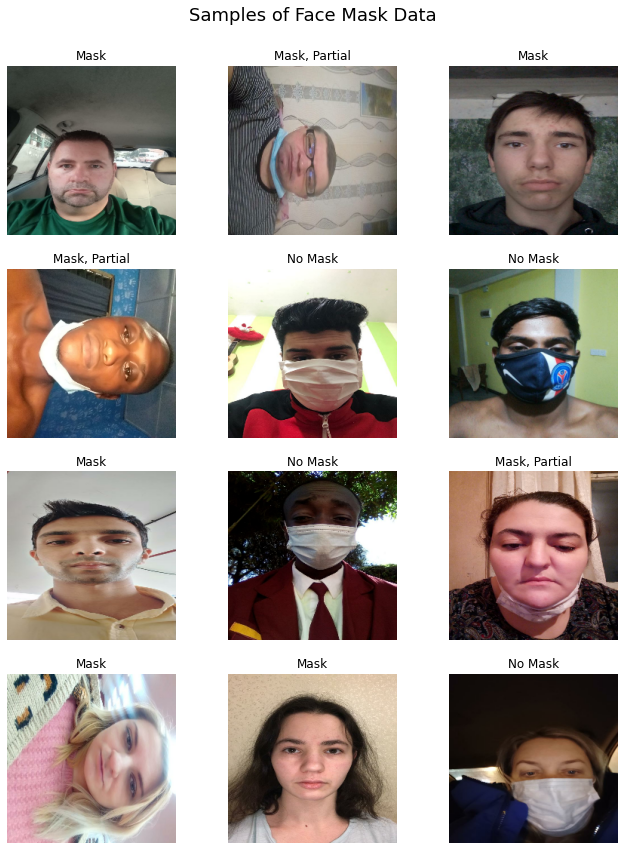

In [4]:
n_rows = 4
n_cols = 3
plt.figure(figsize = (n_cols * 3, n_rows * 3))
for images, labels in valid_ds.take(1):
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        # plt.title(cfg['classes'][int(*np.where(labels[i].numpy() == 1))], fontsize = 12)
        plt.title(cfg['classes'][np.argmax(labels[i])], fontsize = 12)
plt.suptitle('Samples of Face Mask Data\n', fontsize = 18)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

### EfficientNet B3

In [27]:
ENB3 = keras.applications.EfficientNetB3(weights = 'imagenet', 
                                         include_top = False, 
                                         input_shape = inp_sh)
ENB3_model, ENB3_hist = custom_model(ENB3, model_name = 'EfficientNetB3', epochs = 50)
ENB3_model.save('ENB3_model', overwrite = True, include_optimizer = True)
pd.DataFrame(ENB3_hist.history).to_csv('ENB3_hist.csv')

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.1696 - f1: 0.9465 - acc: 0.9464 - auc: 0.9594 - precision: 0.9492 - recall: 0.9440INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


625/625 [==============================] - 101s 151ms/step - loss: 0.1696 - f1: 0.9465 - acc: 0.9464 - auc: 0.9594 - precision: 0.9492 - recall: 0.9440 - val_loss: 0.1373 - val_f1: 0.9582 - val_acc: 0.9580 - val_auc: 0.9686 - val_precision: 0.9584 - val_recall: 0.9580
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.1113 - f1: 0.9632 - acc: 0.9632 - auc: 0.9723 - precision: 0.9642 - recall: 0.9625INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


625/625 [==============================] - 91s 146ms/step - loss: 0.1113 - f1: 0.9632 - acc: 0.9632 - auc: 0.9723 - precision: 0.9642 - recall: 0.9625 - val_loss: 0.1355 - val_f1: 0.9651 - val_acc: 0.9650 - val_auc: 0.9738 - val_precision: 0.9656 - val_recall: 0.9648
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 0.1096 - f1: 0.9646 - acc: 0.9647 - auc: 0.9732 - precision: 0.9660 - recall: 0.9635INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


625/625 [==============================] - 92s 147ms/step - loss: 0.1096 - f1: 0.9646 - acc: 0.9647 - auc: 0.9732 - precision: 0.9660 - recall: 0.9635 - val_loss: 0.1313 - val_f1: 0.9641 - val_acc: 0.9644 - val_auc: 0.9730 - val_precision: 0.9648 - val_recall: 0.9638
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.1841 - f1: 0.9533 - acc: 0.9541 - auc: 0.9643 - precision: 0.9569 - recall: 0.9500INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


625/625 [==============================] - 91s 146ms/step - loss: 0.1841 - f1: 0.9533 - acc: 0.9541 - auc: 0.9643 - precision: 0.9569 - recall: 0.9500 - val_loss: 0.1090 - val_f1: 0.9660 - val_acc: 0.9662 - val_auc: 0.9744 - val_precision: 0.9668 - val_recall: 0.9656
Epoch 5/50
625/625 [==============================] - 48s 77ms/step - loss: 0.0954 - f1: 0.9683 - acc: 0.9686 - auc: 0.9760 - precision: 0.9697 - recall: 0.9671 - val_loss: 0.1142 - val_f1: 0.9632 - val_acc: 0.9636 - val_auc: 0.9723 - val_precision: 0.9638 - val_recall: 0.9630
Epoch 6/50
625/625 [==============================] - 47s 76ms/step - loss: 0.0893 - f1: 0.9718 - acc: 0.9721 - auc: 0.9787 - precision: 0.9728 - recall: 0.9710 - val_loss: 0.1109 - val_f1: 0.9677 - val_acc: 0.9680 - val_auc: 0.9757 - val_precision: 0.9682 - val_recall: 0.9674
Epoch 7/50
625/625 [==============================] - ETA: 0s - loss: 0.0825 - f1: 0.9719 - acc: 0.9721 - auc: 0.9788 - precision: 0.9729 - recall: 0.9711INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: EfficientNetB3_custom_model\assets


625/625 [==============================] - 93s 149ms/step - loss: 0.0825 - f1: 0.9719 - acc: 0.9721 - auc: 0.9788 - precision: 0.9729 - recall: 0.9711 - val_loss: 0.1088 - val_f1: 0.9676 - val_acc: 0.9676 - val_auc: 0.9756 - val_precision: 0.9682 - val_recall: 0.9672
Epoch 8/50
625/625 [==============================] - 48s 77ms/step - loss: 0.0816 - f1: 0.9716 - acc: 0.9719 - auc: 0.9786 - precision: 0.9724 - recall: 0.9711 - val_loss: 0.1240 - val_f1: 0.9667 - val_acc: 0.9666 - val_auc: 0.9750 - val_precision: 0.9670 - val_recall: 0.9666
Epoch 9/50
625/625 [==============================] - 48s 77ms/step - loss: 0.0862 - f1: 0.9725 - acc: 0.9725 - auc: 0.9791 - precision: 0.9736 - recall: 0.9714 - val_loss: 0.1286 - val_f1: 0.9709 - val_acc: 0.9710 - val_auc: 0.9782 - val_precision: 0.9710 - val_recall: 0.9710
Epoch 10/50
625/625 [==============================] - 48s 77ms/step - loss: 0.0813 - f1: 0.9736 - acc: 0.9739 - auc: 0.9800 - precision: 0.9747 - recall: 0.9726 - val_loss: 0.

INFO:tensorflow:Assets written to: ENB3_model\assets


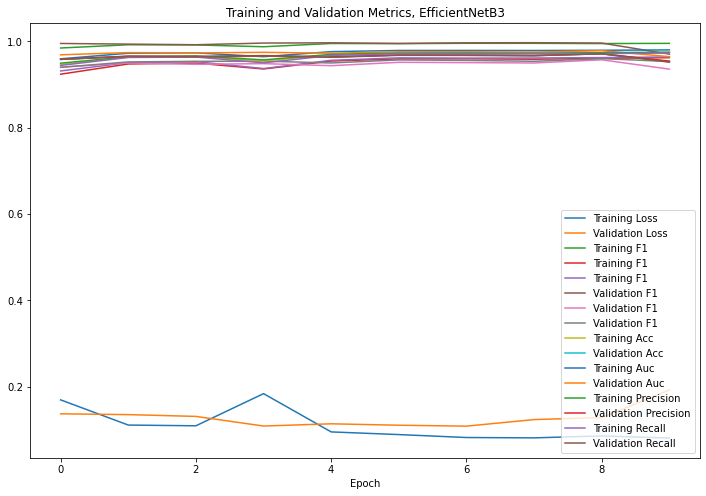

In [28]:
plot_model_hist(ENB3_hist, model_name = 'EfficientNetB3')

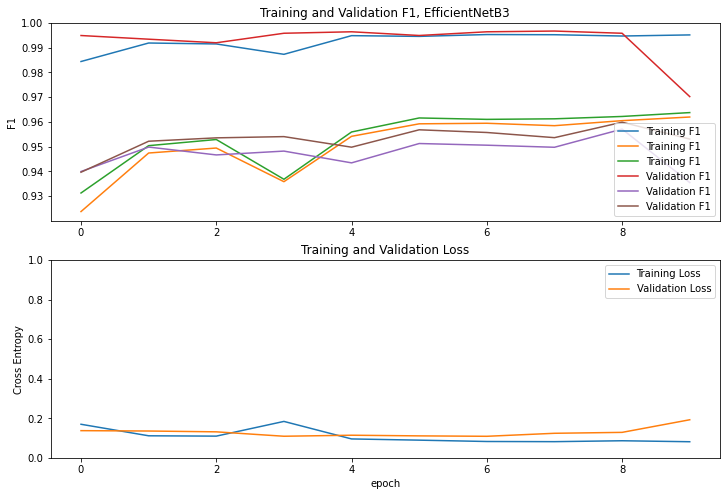

In [29]:
plot_model_f1(ENB3_hist, model_name = 'EfficientNetB3')

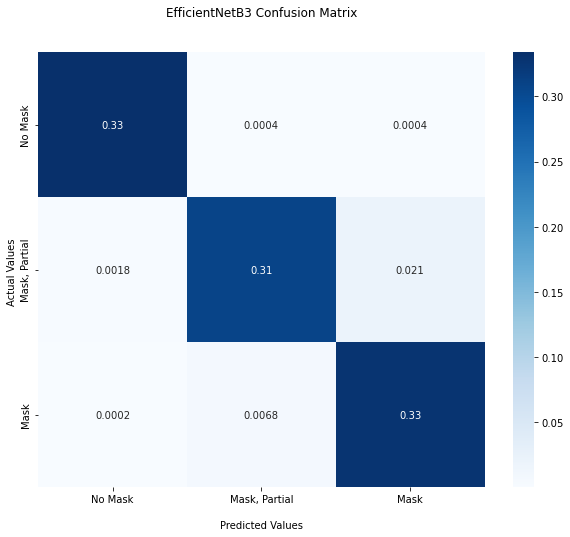

In [12]:
confusion_matrix_plot(ENB3_model, model_name = 'EfficientNetB3')

157/157 [==============================] - 12s 54ms/step - loss: 0.1102 - f1: 0.9697 - acc: 0.9698 - auc: 0.9773 - precision: 0.9698 - recall: 0.9698
[0.11018096655607224, array([0.9958234, 0.9542362, 0.9589924], dtype=float32), 0.9697999954223633, 0.9772806167602539, 0.9697999954223633, 0.9697999954223633]


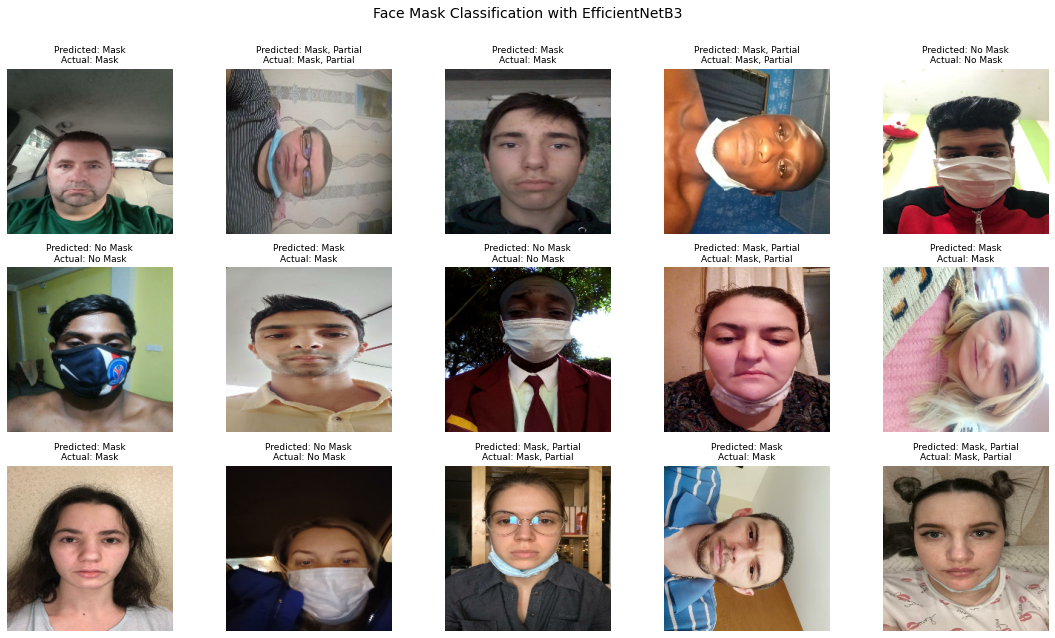

In [13]:
ENB3_results = test_model_visualize(ENB3_model, 'EfficientNetB3')

In [14]:
ENB3_results = test_model_visualize(ENB3_model, 'EfficientNetB3', show_misclassification = True)

157/157 [==============================] - 9s 56ms/step - loss: 0.1102 - f1: 0.9697 - acc: 0.9698 - auc: 0.9773 - precision: 0.9698 - recall: 0.9698
[0.11018096655607224, array([0.9958234, 0.9542362, 0.9589924], dtype=float32), 0.9697999954223633, 0.9772806167602539, 0.9697999954223633, 0.9697999954223633]


<Figure size 1080x648 with 0 Axes>

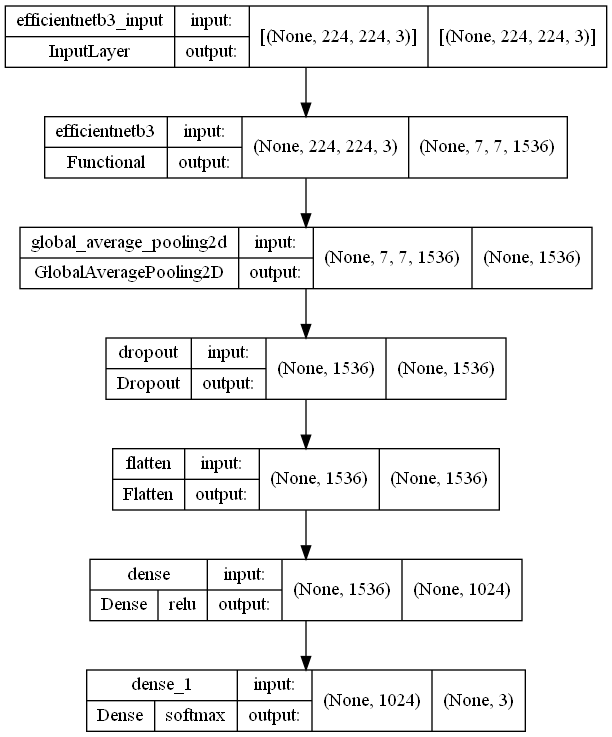

In [15]:
keras.utils.plot_model(ENB3_model, show_shapes = True, show_layer_names = True, show_layer_activations = True)

### MobileNet V3 (Large)

In [21]:
MNV3L = keras.applications.MobileNetV3Large(weights = 'imagenet', 
                                            include_top = False, 
                                            input_shape = inp_sh)
MNV3L_model, MNV3L_hist = custom_model(MNV3L, model_name = 'MobileNetV3Large', epochs = 50)
MNV3L_model.save('MNV3L_model', overwrite = True, include_optimizer = True)
pd.DataFrame(MNV3L_hist.history).to_csv('MNV3L_hist.csv')

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.1823 - f1: 0.9354 - acc: 0.9354 - auc: 0.9504 - precision: 0.9413 - recall: 0.9299

INFO:tensorflow:Assets written to: MobileNetV3Large_custom_model\assets


INFO:tensorflow:Assets written to: MobileNetV3Large_custom_model\assets


625/625 [==============================] - 41s 60ms/step - loss: 0.1823 - f1: 0.9354 - acc: 0.9354 - auc: 0.9504 - precision: 0.9413 - recall: 0.9299 - val_loss: 0.1208 - val_f1: 0.9601 - val_acc: 0.9602 - val_auc: 0.9699 - val_precision: 0.9611 - val_recall: 0.9594
Epoch 2/50
625/625 [==============================] - 20s 31ms/step - loss: 0.0909 - f1: 0.9677 - acc: 0.9679 - auc: 0.9756 - precision: 0.9685 - recall: 0.9671 - val_loss: 0.1548 - val_f1: 0.9579 - val_acc: 0.9578 - val_auc: 0.9683 - val_precision: 0.9580 - val_recall: 0.9578
Epoch 3/50
625/625 [==============================] - 20s 31ms/step - loss: 0.0629 - f1: 0.9778 - acc: 0.9779 - auc: 0.9833 - precision: 0.9783 - recall: 0.9774 - val_loss: 0.1858 - val_f1: 0.9553 - val_acc: 0.9552 - val_auc: 0.9664 - val_precision: 0.9556 - val_recall: 0.9552
Epoch 4/50
625/625 [==============================] - 20s 31ms/step - loss: 0.0562 - f1: 0.9811 - acc: 0.9809 - auc: 0.9857 - precision: 0.9815 - recall: 0.9807 - val_loss: 0.21

INFO:tensorflow:Assets written to: MNV3L_model\assets


INFO:tensorflow:Assets written to: MNV3L_model\assets


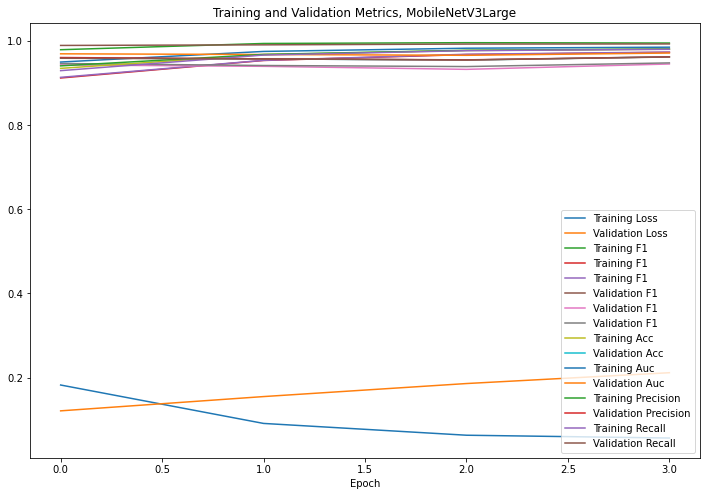

In [22]:
plot_model_hist(MNV3L_hist, model_name = 'MobileNetV3Large')

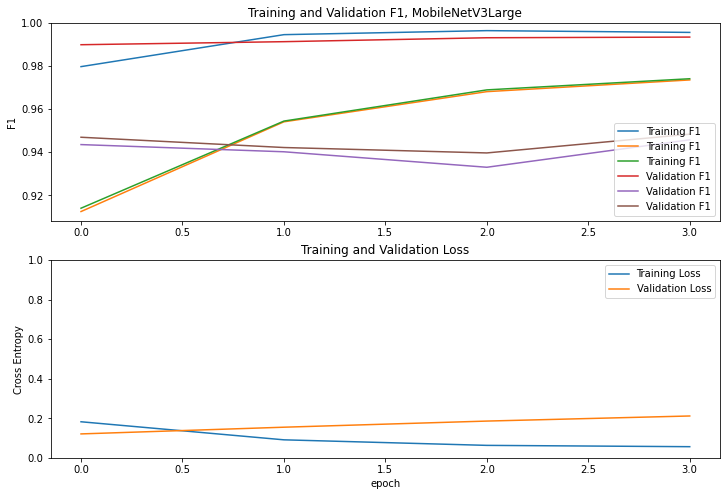

In [23]:
plot_model_f1(MNV3L_hist, model_name = 'MobileNetV3Large')

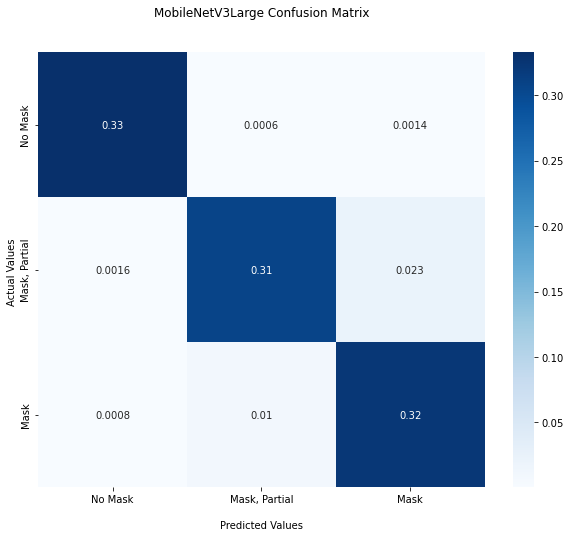

In [24]:
confusion_matrix_plot(MNV3L_model, model_name = 'MobileNetV3Large')

157/157 [==============================] - 4s 23ms/step - loss: 0.2115 - f1: 0.9625 - acc: 0.9628 - auc: 0.9718 - precision: 0.9628 - recall: 0.9624
[0.2115452140569687, array([0.993425  , 0.945746  , 0.94835687], dtype=float32), 0.9628000259399414, 0.9718356132507324, 0.9627851247787476, 0.9624000191688538]


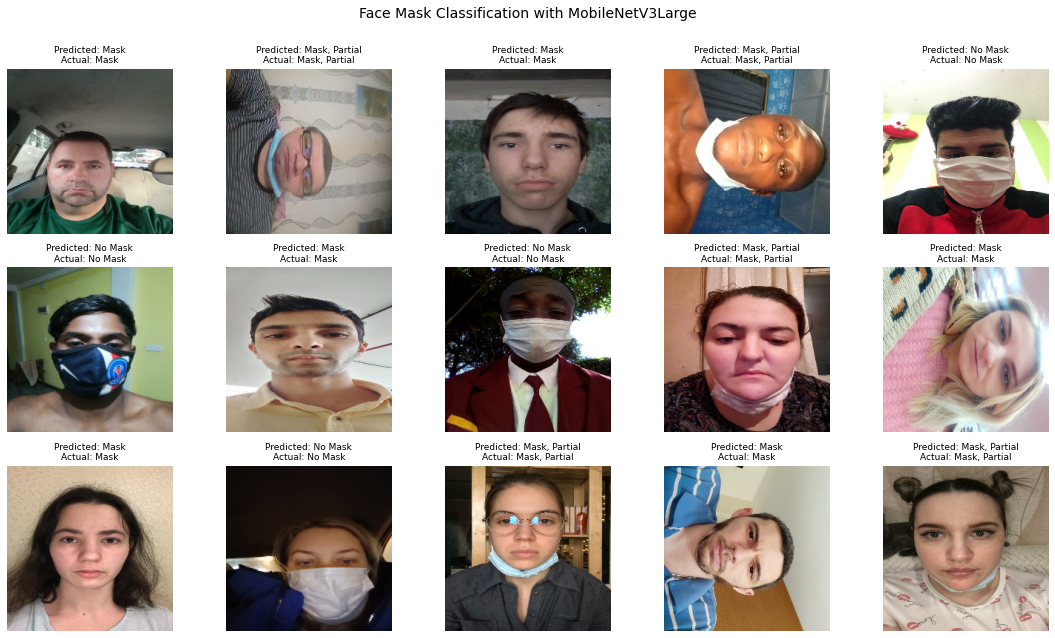

In [25]:
MNV3L_results = test_model_visualize(MNV3L_model, 'MobileNetV3Large')

In [26]:
MNV3L_results = test_model_visualize(MNV3L_model, 'MobileNetV3Large', show_misclassification = True)

157/157 [==============================] - 4s 23ms/step - loss: 0.2115 - f1: 0.9625 - acc: 0.9628 - auc: 0.9718 - precision: 0.9628 - recall: 0.9624
[0.2115452140569687, array([0.993425  , 0.945746  , 0.94835687], dtype=float32), 0.9628000259399414, 0.9718356132507324, 0.9627851247787476, 0.9624000191688538]


<Figure size 1080x648 with 0 Axes>

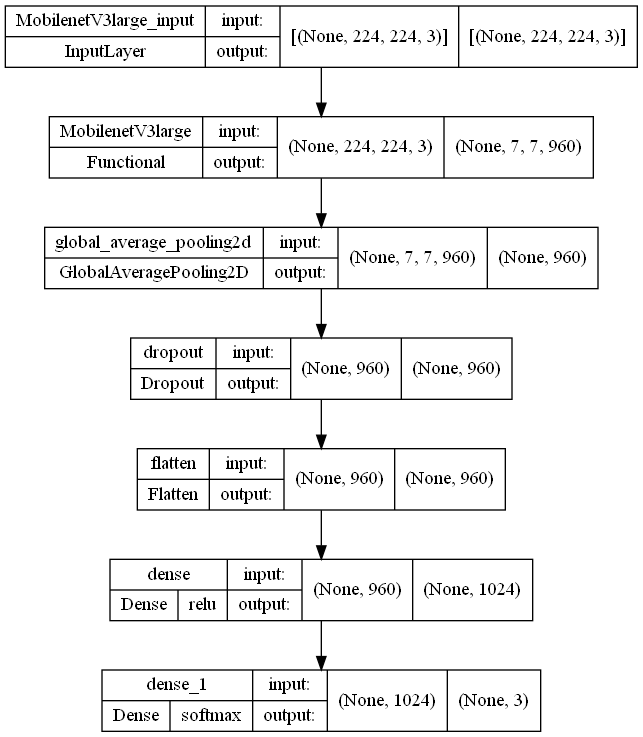

In [30]:
keras.utils.plot_model(MNV3L_model, show_shapes = True, show_layer_names = True, show_layer_activations = True)